# Data & Library import

In [216]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [359]:
data = pd.read_csv("dataset.csv",delimiter=';')
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# Data Pre-Processing

Choosing best feature

In [360]:
# fix label name
data = data.rename({'Nactionality':'Nationality'})

In [361]:
# run only once
le = preprocessing.LabelEncoder()
data["Target"] = le.fit_transform(data["Target"])
# 0 : Drop out 
# 1 : Enrolled
# 2 : Graduate

In [362]:
feature = data.drop(columns=["Target"])
target = data.Target

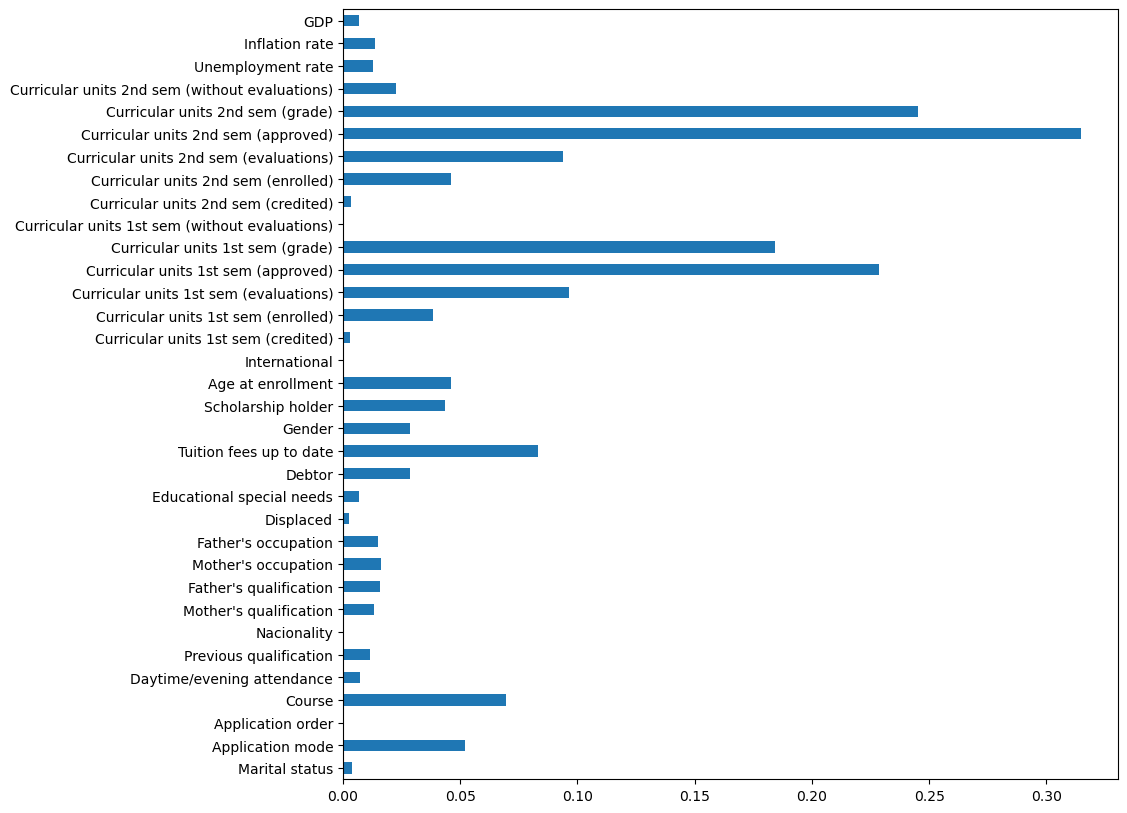

In [363]:
importance = mutual_info_classif(feature,target)
ft_imp = pd.Series(importance, data.columns[0:len(data.columns)-1])
ft_imp.plot(kind="barh",figsize=(10,10))
plt.show()

In [364]:
num_features = 5
largest = ft_imp.nlargest(num_features).index
feature_select = feature[largest]
print(largest)

Index(['Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (evaluations)'],
      dtype='object')


[0 2 0 ... 0 2 2]


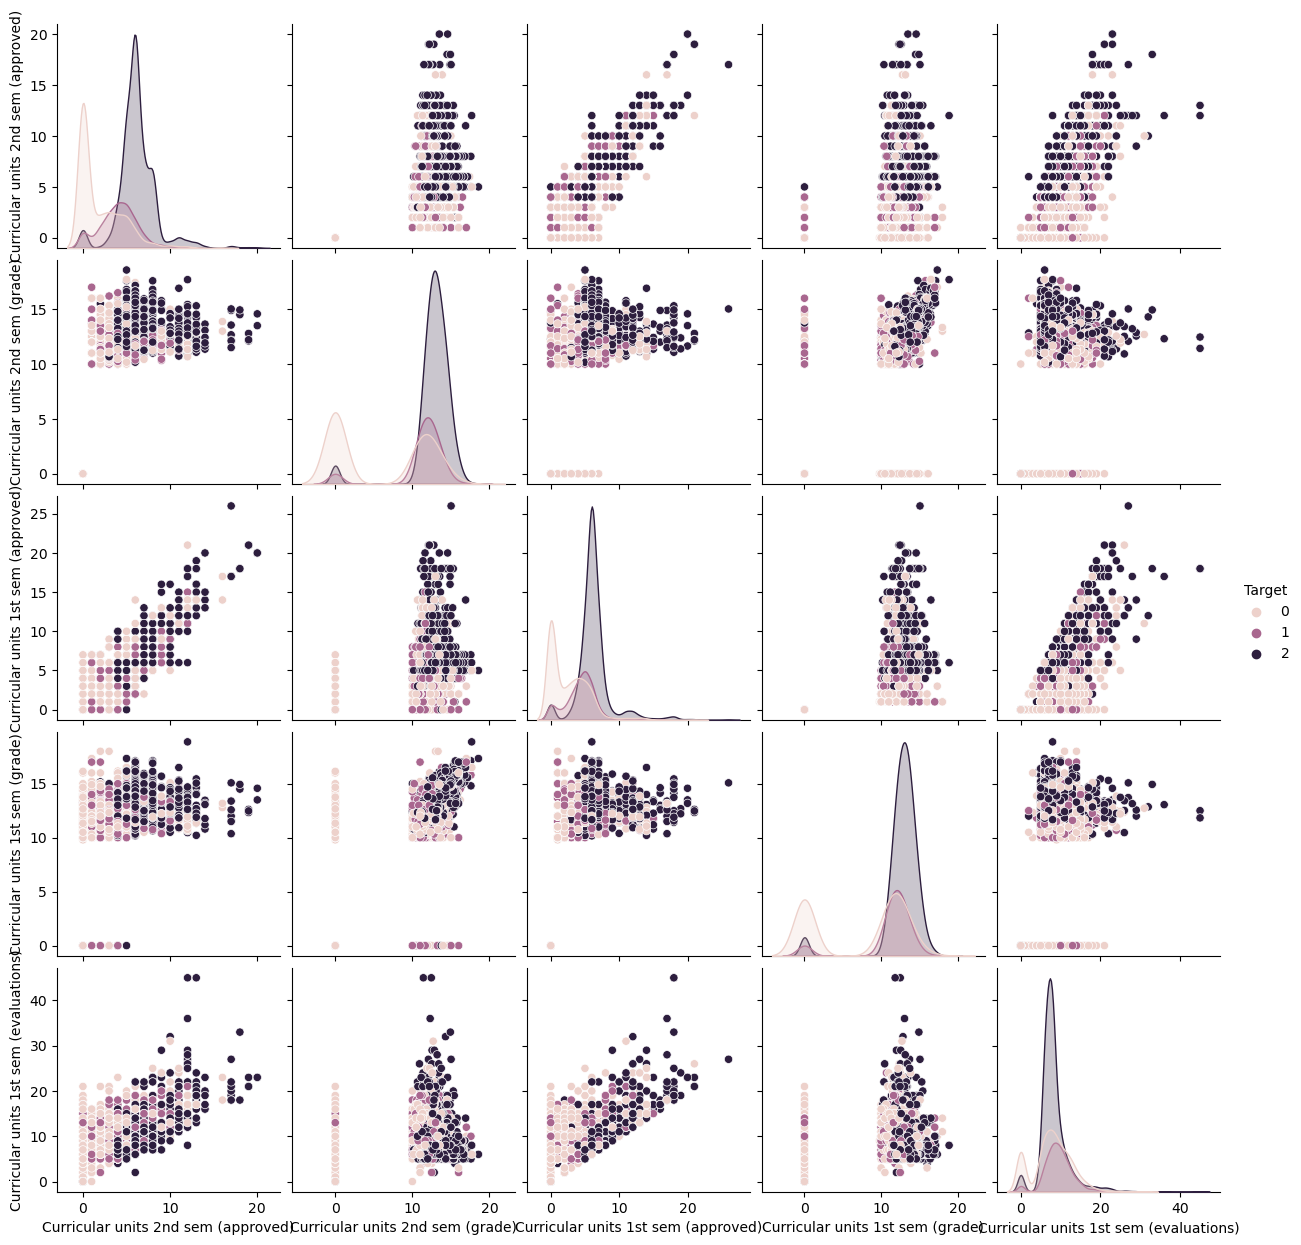

In [388]:
sns.pairplot(feature_select.assign(Target=data.Target.values),hue='Target')
plt.show()

Turning data into tensor

In [389]:
X_train, X_test, Y_train, Y_test = train_test_split(
  feature_select, target, test_size=0.33, random_state=42)

In [390]:
X_train_np = X_train.values
X_test_np = X_test.values
Y_train_np = Y_train.values
Y_test_np = Y_test.values

In [584]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    # need to convert float64 to float32 else 
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X_train.astype(np.float32))
    # need to convert float64 to Long else 
    # will get the following error
    # RuntimeError: expected scalar type Long but found Float
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
  def __len__(self):
    return self.len

In [636]:
traindata = Data(X_train_np,Y_train_np)

In [637]:
batch_size = 100
trainloader = DataLoader(traindata, batch_size=batch_size, 
                         shuffle=True, num_workers=0)

In [638]:
input_dim = num_features
hidden = 50
output_dim = 3

In [660]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(input_dim,hidden)
    self.linear2 = nn.Linear(hidden, output_dim)

  def forward(self, x):
    x = torch.relu(self.linear1(x))
    x = self.linear2(x)
    return x

In [661]:
clf = Network()
print(clf.parameters)

<bound method Module.parameters of Network(
  (linear1): Linear(in_features=5, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=3, bias=True)
)>


In [662]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.001)

# Training

In [663]:
epochs = 200
loss_arr = [i for i in range(epochs)]
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()
    # forward propagation
    outputs = clf(inputs)
    loss = criterion(outputs, labels)
    # backward propagation
    loss.backward()
    # optimize
    optimizer.step()
    running_loss += loss.item()
  # display statistics
  if epoch % 100 == 0:
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.5f}')
  loss_arr[epoch] = running_loss/2000

[1,    30] loss: 0.01859
[101,    30] loss: 0.01055


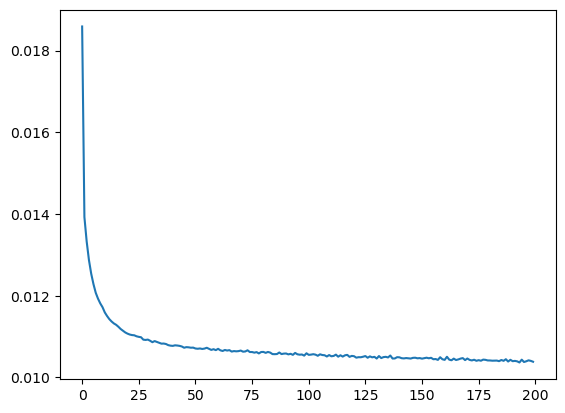

In [664]:
plt.plot(loss_arr)

# Testing

In [665]:
testdata = Data(X_test_np, Y_test_np)
testloader = DataLoader(testdata,batch_size=testdata.len,
                        shuffle=True, num_workers=0)

In [666]:
dataiter = iter(testloader)
inputs, labels = next(dataiter)

In [667]:
outputs = clf(inputs)
__, predicted = torch.max(outputs, 1)

In [668]:
correct, total = 0, 0
# no need to calculate gradients during inference
with torch.no_grad():
  for dat in testloader:
    inputs, labels = dat
    # calculate output by running through the network
    outputs = clf(inputs)
    # get the predictions
    __, predicted = torch.max(outputs.data, 1)
    # update results
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the {len(testdata)} test data: {100 * correct / total} %')

Accuracy of the network on the 1460 test data: 70.20547945205479 %


In [669]:
rand_predictions = np.random.randint(0,3,size=testdata.len)

correct, total = 0, 0
for dat in rand_predictions:
    total += labels.size(0)
    correct += (dat == labels).sum().item()
print(f"{100*correct//total}%")

[2 2 1 ... 2 2 0]
33%
